# Smoothie - demo
This notebook demonstrates the code flow and principles behind the Smoothie application. We first collect all the songs that you've added to your playlists, then create a listening profile for you based on the songs' quantitative properties. To create your profile, we weight each song based on how recently it was added to your playlist; songs added more recently will count more towards your profile.

We then determine which songs everyone is most likely to like based on whether its properties (outlined in Spotify's documentation [here](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features)) are suited to everyone's tastes. We then randomly sample songs from each person's set of songs based on this likelihood.

In this notebook, we'll demonstrate this process by using two of your own playlists and creating profiles using just the songs in each playlist. Try to choose two playlists that may have some overlap in similar songs, but also have some songs that might not go so well in the other.

In [1]:
from api.runtime.util.auth.AuthorizationHandler import AuthorizationHandler
from api.runtime.util.data_objects.User import User
from api.runtime.util.data_objects.Song import Song
from api.runtime.util.data_objects.Playlist import Playlist
from api.runtime.util.bullet.SongProfile import SongProfile
from api.runtime.util.spotify import gateway, playlist_apis, user_apis, track_apis
from api.runtime.util.bullet.ProfileMatcher import ProfileMatcher
from api.runtime.util.bullet.SongProfile import SongProfile
import aiohttp
import urllib
import getpass
import time
import dataclasses
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
async def get_client_session():
    # create ClientSession in coroutine for safety
    return aiohttp.ClientSession()
session = await get_client_session()

Since Spotify requires a login page with user interaction, we'll need to perform this first step in a browser page. Copy and paste the result of the next cell into a browser and approve access to your Spotify account.

In [3]:
redirect_uri = "https://google.com"
print(f'https://accounts.spotify.com/authorize?client_id={os.environ.get("SPOTIFY_CLIENT_ID")}&response_type=code&redirect_uri={urllib.parse.quote_plus(redirect_uri)}&scope=playlist-modify-public,playlist-read-private')

https://accounts.spotify.com/authorize?client_id=c6571c2bc3f444a18ad0308ab4b712f3&response_type=code&redirect_uri=https%3A%2F%2Fgoogle.com&scope=playlist-modify-public,playlist-read-private


Now, in the resulting `google.com` url, copy all the text after `code=`, and enter it when prompted in the next cell

In [4]:
code = getpass.getpass(prompt='Code from URL? ')
me = User(code=code)

Code from URL? ········


Get access/refresh tokens for use with future API calls and assign them to the user

In [5]:
response = await AuthorizationHandler.request_access_token(session, code, redirect_uri)
me.access_token = response['access_token']
me.refresh_token = response['refresh_token']
me.token_expiration_time = int(time.time()) + response['expires_in']

Fetch the rest of your user information (user ID, display name) and all playlists that you've created

In [6]:
response = await user_apis.get_profile(session, me)
me.user_id = response['id']
me.display_name = response['display_name']
playlist_list = await playlist_apis.get_current_users_playlists(session, me)

Replace the two playlist names below with names of playlists from your own profile for which you'd like to create a curated playlist.

In [7]:
wanted_playlists = ['BOPIS (poop 3.2.2)', 'semi-chill (aka poop 2.7)']

First, use the track data available from the playlist APIs to form a list of tracks with weights calculated based off the date they were added to the playlist. Song weights are calculated based on an exponential drop off with respect to time. So, songs that you've added to your playlists more recently will count more towards your overall listening profile. 

The absolute value of the weights doesn't matter; they are normalized before processing any data. Another property of the exponential distribution is that the relative weights between songs will always remain the same, no matter when you calculate them.

In [8]:
def weight_from_add_date(ref_time, added_time):
#     return 1
    LAMBDA = 0.01
    added_time = pd.to_datetime(added_time).timestamp()
    time_diff = ref_time - added_time
    time_diff = time_diff / (60 * 60 * 24) # convert time difference from seconds to days
    return np.exp(-LAMBDA * time_diff)

def insert_trackids_and_weights(track_list, song_df):
    for track in track_list:
        if not track['track']['id']:
            continue
        track_id = track['track']['id']
        previous_weight = song_df.loc[track_id].weight if track_id in song_df.index else 0
        song_df.loc[track_id] = {
            'weight': previous_weight + weight_from_add_date(time.time(), track['added_at']),
            'id': track_id
        }

            
fields = {field.name: field.type for field in dataclasses.fields(Song)}
song_dfs = []


# For each playlist, create a DataFrame containing track ids and weights. These will serve as the basis
# for the "listening profiles" we're creating from the single playlists.
for i, playlist_name in enumerate(wanted_playlists):
    # get all tracks in the playlist
    playlist_id = [playlist['id'] for playlist in playlist_list if playlist['name'] == playlist_name][0]
    track_list = await playlist_apis.get_playlist(session, me, playlist_id)
    
    # create a DataFrame containing all possible Spotify audio features for a track, plus a column for weights
    song_df = pd.DataFrame(
        columns=[*fields.keys(), 'weight'],
        index=[track['track']['id'] for track in track_list]
    )
    
    # We need all weights to start at 0, so set all default NaN values to 0.
    song_df.loc[pd.isna(song_df['weight'])] = 0
    
    insert_trackids_and_weights(track_list, song_df)
    song_dfs.append(song_df)


song_dfs[0]

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence,weight
11xILcyUmIjr2XpM6mpEvA,NaN,NaN,NaN,NaN,NaN,11xILcyUmIjr2XpM6mpEvA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019746
3IjggA4afQs8t5rUQCBgLF,NaN,NaN,NaN,NaN,NaN,3IjggA4afQs8t5rUQCBgLF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019748
7Ffgp7DIow5wECYQyzEiTq,NaN,NaN,NaN,NaN,NaN,7Ffgp7DIow5wECYQyzEiTq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019748
2Sxh2q1QIepsL1FBVY8HTh,NaN,NaN,NaN,NaN,NaN,2Sxh2q1QIepsL1FBVY8HTh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01975
08iZ1xoqxBCzoZJjXdZKKa,NaN,NaN,NaN,NaN,NaN,08iZ1xoqxBCzoZJjXdZKKa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01975
3BeQzzSxNb7lzN1pJwXXDf,NaN,NaN,NaN,NaN,NaN,3BeQzzSxNb7lzN1pJwXXDf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019757
73tyOM7hObuzyqG1smXMnh,NaN,NaN,NaN,NaN,NaN,73tyOM7hObuzyqG1smXMnh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019758
0h11wE1hTwKMxYd1NACgNb,NaN,NaN,NaN,NaN,NaN,0h11wE1hTwKMxYd1NACgNb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019758
68OnIh4v10tWxZYJTsHJWX,NaN,NaN,NaN,NaN,NaN,68OnIh4v10tWxZYJTsHJWX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019759
79SwVzOYeZANQKa8v9IM8I,NaN,NaN,NaN,NaN,NaN,79SwVzOYeZANQKa8v9IM8I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019841


Save the data as needed so that this data doesn't have to be fetched again; the track ids are sufficient to fill in the rest of the information. However, the data will need to be re-queried if the weight function changes.

In [11]:
for i, name in enumerate(wanted_playlists):
    song_dfs[i].to_csv(name + '.csv')

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence,added_at,weight


Read the data from the saved csv file. This is not needed when running the cells sequentially.

In [6]:
song_dfs = []
for i, name in enumerate(wanted_playlists):
    song_dfs.append(pd.read_csv(name + '.csv', index_col=0))

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence,added_at,weight
25GlFJq5QNAXyVgJvCZ4Mf,NaN,NaN,NaN,NaN,NaN,25GlFJq5QNAXyVgJvCZ4Mf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1zlclNkERGFrCxznXOgkD3,NaN,NaN,NaN,NaN,NaN,1zlclNkERGFrCxznXOgkD3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5bBUDJUfGcG7eFy3Bf4fXv,NaN,NaN,NaN,NaN,NaN,5bBUDJUfGcG7eFy3Bf4fXv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4M2t7bP4Mq87mGMn0PObUX,NaN,NaN,NaN,NaN,NaN,4M2t7bP4Mq87mGMn0PObUX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
67pIYW0MEQWWkNvuXb70vC,NaN,NaN,NaN,NaN,NaN,67pIYW0MEQWWkNvuXb70vC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35p6JlvO7rnbC2R3zaXbXu,NaN,NaN,NaN,NaN,NaN,35p6JlvO7rnbC2R3zaXbXu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1IsF8TjXjTDd7wZVX258zf,NaN,NaN,NaN,NaN,NaN,1IsF8TjXjTDd7wZVX258zf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7jQhyzqfbLjQwEFUrWsaYE,NaN,NaN,NaN,NaN,NaN,7jQhyzqfbLjQwEFUrWsaYE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3Plz0TdhMQNOorsOXmKdvR,NaN,NaN,NaN,NaN,NaN,3Plz0TdhMQNOorsOXmKdvR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


Spotify exposes an API to get the audio features for up to 100 tracks at once. Read track ids in chunks from the dataframe and then fill in the additional data.

In [9]:
# iterate over chunks of song_df
# for all audio features in the response, update each row in song_df by id
for song_df in song_dfs:
    for i in range(int(len(song_df) / 100 + 1)):
        id_list = list(song_df.id.iloc[100*i: min(100*(i+1), len(song_df))])
        audio_features = await track_apis.get_audio_features_for_several_tracks(session, me, id_list)
        for song in audio_features:
            song_df.loc[song['id'], song.keys()] = song

When creating song profiles we smooth the data so that, for each quantitative dimension shown in the dataframe above, we create features instead of spiky areas. This is done using a Gaussian blur, which effectively smears the data and allows one histogram bin to "bleed into" its neighbors, kind of like a blurry photo. This next cell demonstrates this idea. Note how the data gets smoothed into a profile that represents features, not specific bins with high counts.

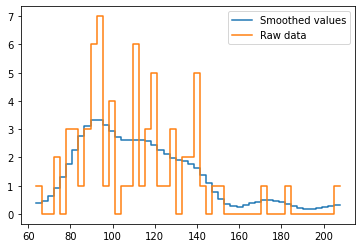

In [10]:
def plot_line_histogram(bin_content, bin_edges, label, ax=None):
    left_edges = bin_edges[:-1]
    right_edges = bin_edges[1:]
    X = np.array([left_edges, right_edges]).T.flatten()
    Y = np.array([bin_content, bin_content]).T.flatten()
    axis = ax if ax else plt
    axis.plot(X, Y, label=label)
    
matcher = ProfileMatcher()
for song_df in song_dfs:
    matcher.add_profile(SongProfile(None, song_df))

for feature in SongProfile.relevant_features:
    dimensions = [profile.features[feature] for profile in matcher.profiles]
    matcher.bin_and_smooth_dimensions(dimensions)

feature = 'tempo'
plylst = 1
feature_dimension = matcher.profiles[plylst].features[feature]
bin_edges = feature_dimension.bin_edges
raw, _ = np.histogram(song_dfs[plylst][feature], bins=len(bin_edges)-1, range=(bin_edges[0], bin_edges[-1]))
plot_line_histogram(feature_dimension.binned_values * np.sum(raw), feature_dimension.bin_edges, 'Smoothed values')
plot_line_histogram(raw, feature_dimension.bin_edges, 'Raw data')
plt.legend()
plt.show()

That looks good! Now, let's take a look at how two profiles which are very similar in certain areas will result in a strong similarity:

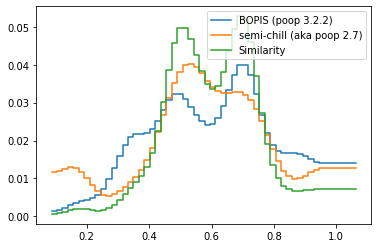

In [11]:
similarity_profile = matcher.match_profiles()
similarity = similarity_profile.feature_similarities

feature = 'valence'
for i in range(2):
    feature_dimension = matcher.profiles[i].features[feature]
    plot_line_histogram(feature_dimension.binned_values, feature_dimension.bin_edges, wanted_playlists[i])

plot_line_histogram(similarity[feature] / np.sum(similarity[feature]), feature_dimension.bin_edges, 'Similarity')
plt.legend()
plt.show()

This looks good, too. Looking at the extreme behaviors, the Similarity trend is low when both profiles are low and peaks when both trends are high. The behavior in the middle is also as expected; not as low as the lowest lows, but certainly not competing when both profiles agree with each other.

Now, let's create a playlist based off of these similarities. We'll first sample the songs using these similarities as a "probability distribution function" (really probability mass function), then post the playlist to your Spotify account

In [12]:
# Run this cell separately in case something errors out in the next one;
# we don't need to create multiple playlists in your account
playlist_id = await playlist_apis.create_playlist(session, me, "Smoothie", description="Test playlist")

In [13]:
playlist_uris = matcher.create_playlist()
await playlist_apis.add_to_playlist(session, me, playlist_id, list(playlist_uris))

And there you have it! You should have a shiny new playlist in your spotify account called **Smoothie**!